In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import shutil
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras

In [2]:
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)

df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)
df.drop("support_material", axis=1, inplace=True)

df.head()

,volume,area,n_triangles,x_scale,y_scale,z_scale,area_ratio_xy,area_ratio_xz,area_ratio_yz,build_time,model_material,area_ground,box_volume
0,98.344215,420.096211,652,9.144006,0.50800,22.013333,2.398148,1.923505,1.999995,435,109.838,4.645153,102.255309
1,3.726959,26.368342,564,6.032647,1.15000,1.234622,1.216648,1.991790,2.678573,30,5.057,6.937544,8.565246
2,1.315050,11.516920,2454,1.650000,1.65000,1.390008,1.028467,2.060714,2.113780,28,2.563,2.722500,3.784297
3,4.134664,20.899255,1152,2.000000,2.25849,1.650000,2.081730,1.906478,1.953626,29,5.198,4.516980,7.453017
4,927.755856,1253.666592,31880,25.400000,25.40000,8.375590,0.727910,3.029799,3.045351,766,874.206,645.160000,5403.595894


In [3]:
#Extract build times
dfcopy = df.copy()
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)
build_times.head()

0    435
1     30
2     28
3     29
4    766
Name: build_time, dtype: int64

In [4]:
#Train/test split
xtrain, xtest, ytrain, ytest = train_test_split(df, build_times, test_size=0.2)

In [5]:
#Make pipeline
#https://joaquinamatrodrigo.github.io/skforecast/0.5.1/user_guides/sklearn-transformers-and-pipeline.html

def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 


logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

In [6]:
#Xdata pipe fit
xlabels = xtrain.columns.values

xtrain = pipe.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain)
xtrain.columns = xlabels

print(xtest.head())
xtest = pipe.transform(xtest)
xtest = pd.DataFrame(xtest)
xtest.columns = xlabels
print(xtest.head())

         volume        area  n_triangles    x_scale    y_scale   z_scale  \
46    16.386163  125.024258         2220   2.634412   2.623847  8.098779   
1701  63.348636  433.763828       345996  16.694638   7.911137  4.208379   
3423  91.390815  248.459609          868   4.069800  20.499802  1.240000   
1699   8.526674   80.814419           36   2.377641   2.261271  5.700000   
362   46.657899  179.674844         1752   6.967062   6.947266  4.295972   

      area_ratio_xy  area_ratio_xz  area_ratio_yz  model_material  \
46         0.812219       3.573083       3.568259          17.206   
1701       1.920012       3.173722       4.602365          65.060   
3423       1.922067       2.398057       3.279922          88.089   
1699       1.381966       3.504528       3.504528           8.071   
362        1.162822       2.795995       2.714557          49.768   

      area_ground  box_volume  
46       6.912293   55.981136  
1701   132.073563  555.815605  
3423    83.430097  103.453324  


In [7]:
#Convert to tensors
xtraint = tf.convert_to_tensor(xtrain)
ytraint = tf.convert_to_tensor(ytrain)
xtestt = tf.convert_to_tensor(xtest)
ytestt = tf.convert_to_tensor(ytest)

In [8]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [185]:
#Single layer tuner
#https://www.analyticsvidhya.com/blog/2021/06/keras-tuner-auto-neural-network-architecture-selection/

#Remove old search
try:
    shutil.rmtree("single_layer_tuning")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(13,))

  hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mae', metrics = ['mape'])
  return model

tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mae',
    max_trials = 10,
    executions_per_trial = 3,
    project_name = "single_layer_tuning"
)

tuner.search_space_summary()

Error: single_layer_tuning - Het systeem kan het opgegeven pad niet vinden.
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [186]:
#Search
tuner.search(xtraint, ytraint, epochs=5, validation_data=(xtestt, ytestt))

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 37s
INFO:tensorflow:Oracle triggered exit


In [187]:
#Results
tuner.results_summary(1)

Results summary
Results in .\single_layer_tuning
Showing 1 best trials
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0001
Score: 0.0


In [18]:
#Multiple layer tuner
#https://www.analyticsvidhya.com/blog/2021/06/keras-tuner-auto-neural-network-architecture-selection/
#https://pub.towardsai.net/keras-tuner-tutorial-hyperparameter-optimization-tensorflow-keras-computer-vision-example-c9abbdad9887

#Remove old search
try:
    shutil.rmtree("multiple_layers_tuning")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(12,))

  hp_layers = hp.Int("layers", min_value=1, max_value=5, step=1)
  
  for i in range(hp_layers):
    model.add(tf.keras.layers.Dense(units=hp.Int(f"units_{i}", min_value=8, max_value=256, step=8), activation='relu'))

  
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mape', metrics = ['mae', 'mape'])
  return model

tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mape',
    max_trials = 10,
    executions_per_trial = 1,
    project_name = "multiple_layers_tuning"
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [19]:
#Search
tuner.search(xtraint, ytraint, epochs=200, validation_data=(xtestt, ytestt), callbacks=get_callbacks('baseline_nosupp_tuner',
                                                                                                    patience=50,
                                                                                                    lr_factor=0.2))

Trial 251 Complete [00h 03m 20s]
val_mape: 28.006498336791992

Best val_mape So Far: 11.070463180541992
Total elapsed time: 01h 25m 15s

Search: Running Trial #252

Value             |Best Value So Far |Hyperparameter
4                 |5                 |layers
88                |248               |units_0
0.0001            |0.001             |learning_rate
40                |128               |units_1
128               |232               |units_2
112               |168               |units_3
88                |208               |units_4
200               |200               |tuner/epochs
0                 |67                |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/200
92/92 [==============================] - 2s 17ms/step - loss: 90.5995 - mae: 254.3487 - mape: 90.5995 - val_loss: 75.0074 - val_mae: 269.6422 - val_mape: 75.0074 - lr: 1.0000e-04
Epoch 2/200
92/92 [==============================] -

KeyboardInterrupt: 

In [20]:
#Results
tuner.results_summary(1)

Results summary
Results in .\multiple_layers_tuning
Showing 1 best trials
Trial summary
Hyperparameters:
layers: 5
units_0: 248
learning_rate: 0.001
units_1: 128
units_2: 232
units_3: 168
units_4: 208
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 11.070463180541992


In [10]:
#Build new model
model = tf.keras.Sequential([
                               tf.keras.layers.Input(12,name='baselineinput'),
                               tf.keras.layers.Normalization(),
                               tf.keras.layers.Dense(8, activation='relu'),
                               tf.keras.layers.Dense(24, activation='relu'),
                               tf.keras.layers.Dense(136, activation='relu'),
                               tf.keras.layers.Dense(232, activation='relu'),
                               tf.keras.layers.Dense(232, activation='relu'),
                               tf.keras.layers.Dropout(0.5, name='dropbaseline'),
                               tf.keras.layers.Dense(1)
])
model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae',tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 dense_6 (Dense)             (None, 24)                216       
                                                                 
 dense_7 (Dense)             (None, 136)               3400      
                                                                 
 dense_8 (Dense)             (None, 232)               31784     
                                                                 
 dense_9 (Dense)             (None, 232)               54056     
                                                      

In [ ]:
#Naive fit model
model.fit(xtraint, ytraint, epochs=400, verbose=0)

In [122]:
#Test new model
preds = model.predict(xtestt)

mae = tf.metrics.mean_absolute_error(y_true=ytestt, y_pred=preds.squeeze()).numpy()
print(f"Mean absolute error: {mae}")

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_true=ytestt, y_pred=preds.squeeze())
print(f"Mean percentage error: {m.result().numpy()}")


35/35 [==============================] - 0s 2ms/step
Mean absolute error: 21.534584045410156
Mean percentage error: 12.700477600097656


In [11]:
#Fit with callbacks
history = model.fit(xtraint, ytraint, validation_data=(xtestt, ytestt), epochs=1000, verbose=1,
                    callbacks=get_callbacks('savedmodels/remove',
                                            patience=60,
                                            lr_factor=0.2))



Epoch 1/1000
92/92 [==============================] - 3s 18ms/step - loss: 66.1126 - mae: 232.5914 - mape: 66.1126 - val_loss: 55.3307 - val_mae: 276.7819 - val_mape: 55.3307 - lr: 0.0010
Epoch 2/1000
92/92 [==============================] - 2s 17ms/step - loss: 51.0438 - mae: 213.9786 - mape: 51.0438 - val_loss: 51.0305 - val_mae: 272.7459 - val_mape: 51.0305 - lr: 0.0010
Epoch 3/1000
92/92 [==============================] - 1s 15ms/step - loss: 49.0380 - mae: 210.8426 - mape: 49.0380 - val_loss: 50.9779 - val_mae: 266.5056 - val_mape: 50.9779 - lr: 0.0010
Epoch 4/1000
92/92 [==============================] - 2s 18ms/step - loss: 49.0016 - mae: 209.0781 - mape: 49.0016 - val_loss: 48.8676 - val_mae: 270.3101 - val_mape: 48.8676 - lr: 0.0010
Epoch 5/1000
92/92 [==============================] - 2s 18ms/step - loss: 48.4661 - mae: 207.9494 - mape: 48.4661 - val_loss: 48.4996 - val_mae: 263.3173 - val_mape: 48.4996 - lr: 0.0010
Epoch 6/1000
92/92 [==============================] - 2s 19m

In [11]:
#Test new model
preds = model.predict(xtestt)

mae = tf.metrics.mean_absolute_error(y_true=ytestt, y_pred=preds.squeeze()).numpy()
print(f"Mean absolute error: {mae}")

mape = tf.metrics.mape(y_true=ytestt, y_pred=preds.squeeze())
print(f"Mean percentage error: {mape}")

23/23 [==============================] - 0s 4ms/step
Mean absolute error: 30.83456039428711
Mean percentage error: 21.921464920043945


<function matplotlib.pyplot.show(close=None, block=None)>

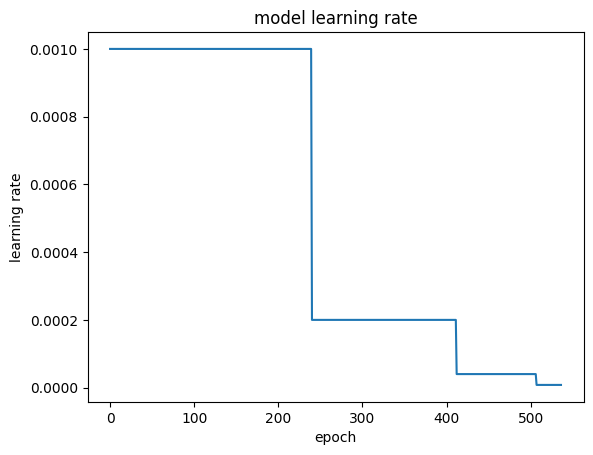

In [19]:
#Plot learning rate
plt.plot(history.history["lr"])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

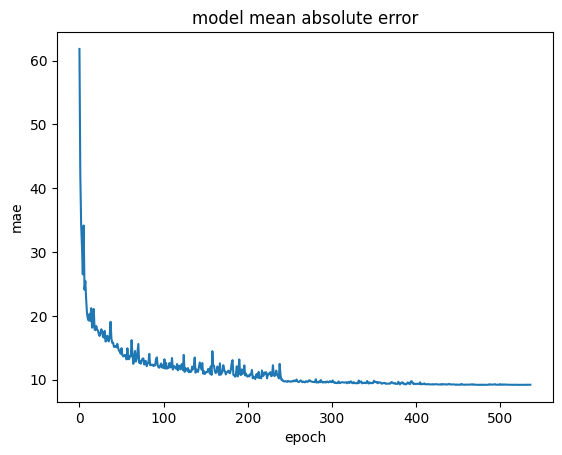

In [20]:
#Plot mae
plt.plot(history.history["val_mape"])
plt.title('model mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show